In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
import sys, os

sys.path.append( os.path.abspath('../'))
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 200)

%load_ext autoreload 
%autoreload 2

import custom_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [2]:
import joblib
df = joblib.load('Data_NLP/processed_reviews_v2.joblib')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7254 entries, 0 to 8649
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_id       7254 non-null   object
 1   movie_id        7254 non-null   int64 
 2   imdb_id         7254 non-null   object
 3   original_title  7254 non-null   object
 4   review          7254 non-null   object
 5   new_rating      2026 non-null   object
 6   lower_review    7254 non-null   object
 7   tokens          7254 non-null   object
 8   clean_tokens    7254 non-null   object
 9   spacy_lemmas    7254 non-null   object
 10  tokens_joined   7254 non-null   object
 11  lemmas_joined   7254 non-null   object
dtypes: int64(1), object(11)
memory usage: 736.7+ KB


,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens,spacy_lemmas,tokens_joined,lemmas_joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into ...,None,this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into ...,"[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, st...","[fine, piece, cinema, wong, kar-wai, tells, us, story, two, people, circumstance, throws, together, way, might, expect, start, two, couples, move, new, building, one, newspaper, man, wife, busines...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, hom...",fine piece cinema wong kar-wai tells us story two people circumstance throws together way might expect start two couples move new building one newspaper man wife business executive wife businessma...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave in...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommende...",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommende...","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british,...","[guilty, pleasure, personally, love, 'the, great, escape, works, seen, years, rightfully-esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love 'the great escape works seen years rightfully-esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from th...",None,"ok, there is an huge temptation to riddle this review with puns - but i'm just going to say it's a cracking little family adventure. it's seemingly based on a whole range of classic movies from th...","[ok, ,, there, is, an, huge, temptation, to, riddle, this, review, with, puns, -, but, i, 'm, just, going, to, say, it, 's, a, cracking, little, family, adventure, ., it, 's, seemingly, based, on,...","[ok, huge, temptation, riddle, review, puns, 'm, going, say, 's, cracking, little, family, adventure, 's, seemingly, based, whole, range, classic, movies, ``, great, escape, '', ``, star, trek, ''...","[ok, huge, temptation, riddle, review, pun, go, crack, little, family, adventure, seemingly, base, range, classic, movie, great, escape, star, trek, love, story, score, cannibalise, write, messrs....",ok h

In [3]:
df.shape

(7254, 12)

In [4]:
df['new_rating'].isna().sum()

5228

In [5]:
df = df.dropna()
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens,spacy_lemmas,tokens_joined,lemmas_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommende...",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommende...","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british,...","[guilty, pleasure, personally, love, 'the, great, escape, works, seen, years, rightfully-esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love 'the great escape works seen years rightfully-esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motio...,Low,after quite entertainign mission impossible i the second installment turned out ... terrible. as if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motio...,"[after, quite, entertainign, mission, impossible, i, the, second, installment, turned, out, ..., terrible, ., as, if, the, screenwriters, did, n't, know, how, to, fill, the, 2, hrs, with, action, ...","[quite, entertainign, mission, impossible, second, installment, turned, ..., terrible, screenwriters, n't, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, almost, migh...","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, ...",quite entertainign mission impossible second installment turned ... terrible screenwriters n't know fill 2 hrs action overuse heroic slow motion scenes horrible almost might need barf bag ca n't s...,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed de...
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endi...",High,"okay, i will admit i can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endi...","[okay, ,, i, will, admit, i, can, be, a, bit, of, an, easy, grader, when, it, comes, to, romantic, comedies, ,, as, long, as, they, are, witty, with, likable, characters, ,, don, ’, t, insult, my,...","[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, ’, insult, intelligence, suitable, happy, endings, guess, ’, end, happily, ’, rom-coms, saw, movie, ma...","[okay, admit, bit, easy, grader, come, romantic, comedy, long, witty, likable, character, insult, intelligence, suitable, happy, ending, guess, end, happily, rom, com, see, movie, year, 

In [6]:
df.shape

(2026, 12)

In [7]:
#Splitting data for machine learning
X = df['review']
y = df['new_rating']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
len(X_train_full), len(X_test)

(1418, 608)

In [8]:
#Instansiate label encoder
encoder = LabelEncoder()

#Fit and transform the target
y_train_full_enc = encoder.fit_transform(y_train_full)
y_test_enc = encoder.transform(y_test)

y_train_full_enc[:10]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1])

In [9]:
classes = y.unique()
classes

array(['High', 'Low'], dtype=object)

In [10]:
y.value_counts(normalize=True)

High    0.511352
Low     0.488648
Name: new_rating, dtype: float64

In [11]:
#Convert training data to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train_full, y_train_full_enc))
# Shuffle dataset once
train_ds = train_ds.shuffle(len(train_ds),seed=42, reshuffle_each_iteration=False)

In [12]:
#Convert test to dataset object to split
val_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))

#Calculate # of samples for 50/50 val/test split
n_val_samples = int(len(val_test_ds) *.5)
n_val_samples

304

In [13]:
#Creating validation dataset using .take
val_ds = val_test_ds.take(n_val_samples)
#Creating test dataset using .skip
test_ds = val_test_ds.skip(n_val_samples)

#Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(1418, 304, 304)

In [14]:
#  Setting the batch_size for all datasets
BATCH_SIZE =32
# use .batch to add batching to all 3 datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 45 training batches.
 There are 10 validation batches.
 There are 10 testing batches.


In [15]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
# Get just the text_ds from train_ds
text_ds = train_ds.map(lambda x,y: x)
# Preview the text_ds
text_ds.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Is there any excuse available that will justify spending 2 hours, 45 minutes to watch this film?  Or why I am gifting it three stars?\r\n\r\nIt was a free rental at Redox.\r\nI normally enjoy Mark Wahlberg movies.\r\nI love Bumblebee.  \r\n\r\nDo any of these hold water?\r\n\r\nI know one thing that doesn\xe2\x80\x99t hold a lot of water \xe2\x80\x93 the story. Does it really matter at this point in the franchise? There are good guy Transformers called Autobots and bad guy Transformers called Decepticons and standing between them are stupid humans that betray their species for profit \xe2\x80\x93 normally it\xe2\x80\x99s the U.S. Government. BUT wait \xe2\x80\x93 there is one hero that will change all of this and talk Optimus Prime (Autobot Boss Daddy) into fighting one last battle (for the fourth or fifth time \xe2\x80\x93 I\xe2\x80\x99ve lost count at this point) while some hot-looking woman runs around explosions in short-shorts

In [17]:
df['length'] = df['tokens'].map(len)
df['length'].describe()

count    2026.000000
mean      267.187068
std       273.928826
min         1.000000
25%        74.000000
50%       180.000000
75%       360.000000
max      2593.000000
Name: length, dtype: float64

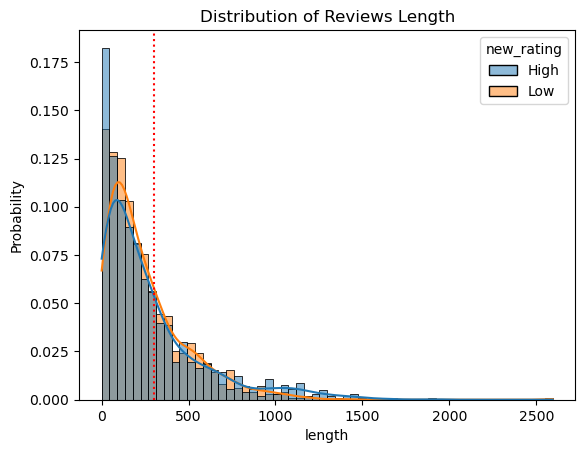

In [18]:
SEQUENCE_LENGTH = 300
ax = sns.histplot(data=df, hue='new_rating', x='length',kde=True,
                stat='probability',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")
ax.set_title('Distribution of Reviews Length');

In [19]:
EMBED_DIM = 100

sequence_vectorizer = tf.keras.layers.TextVectorization(standardize="lower_and_strip_punctuation",
                                                        output_mode="int",
                                                        output_sequence_length=SEQUENCE_LENGTH)

sequence_vectorizer.adapt(text_ds)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

23062

In [40]:
def build_rnn_model(text_vectorization_layer):
    
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add the SimpleRNN layer
    model.add(layers.SimpleRNN(32))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [41]:
## Create text Vectorization layer
SEQUENCE_LENGTH = 150
EMBED_DIM = 100

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(text_ds)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 150, 100)          2306200   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,310,489
Trainable params: 2,310,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
45/45 [==============================] - 1s 23ms/step - loss: 0.7009 - accuracy: 0.4958 - val_loss:

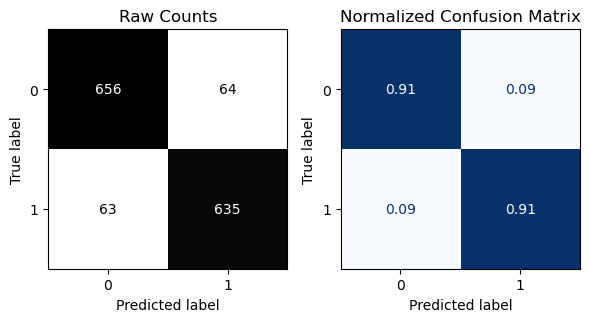


- Evaluating Training Data:
45/45 [==============================] - 0s 5ms/step - loss: 0.2302 - accuracy: 0.9104
{'loss': 0.2301788330078125, 'accuracy': 0.9104372262954712}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       152
           1       0.51      0.47      0.49       152

    accuracy                           0.51       304
   macro avg       0.51      0.51      0.51       304
weighted avg       0.51      0.51      0.51       304



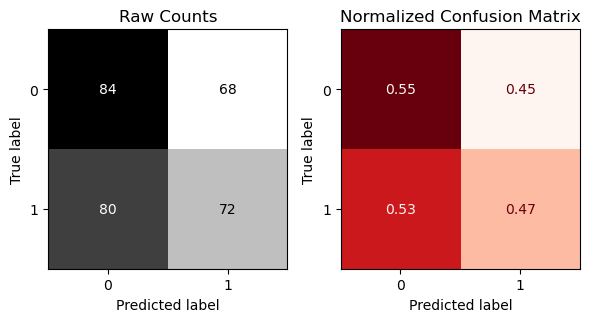


- Evaluating Test Data:
10/10 [==============================] - 0s 5ms/step - loss: 0.8812 - accuracy: 0.5132
{'loss': 0.8811526894569397, 'accuracy': 0.5131579041481018}


In [45]:
rnn_model = build_rnn_model(sequence_vectorizer)
EPOCHS = 30

# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop]
)
results = evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [20]:
rnn_model = Sequential([
    sequence_vectorizer,
    layers.Embedding(input_dim=VOCAB_SIZE,
                              output_dim=EMBED_DIM, 
                              input_length=SEQUENCE_LENGTH)
    ])

# Add *new* layer
rnn_model.add(layers.SimpleRNN(32))
rnn_model.add(layers.Dense(10, activation='relu'))
rnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer='adam',
              loss='bce',
              metrics=['accuracy'])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          2306200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,310,797
Trainable params: 2,310,797
Non-trainable params: 0
______________________________________________

Epoch 1/30
45/45 [==============================] - 2s 34ms/step - loss: 0.5564 - accuracy: 0.6509 - val_loss: 0.7704 - val_accuracy: 0.5526
Epoch 2/30
45/45 [==============================] - 2s 34ms/step - loss: 0.4909 - accuracy: 0.6975 - val_loss: 0.7903 - val_accuracy: 0.4901
Epoch 3/30
45/45 [==============================] - 2s 34ms/step - loss: 0.4935 - accuracy: 0.6749 - val_loss: 0.7937 - val_accuracy: 0.5395
Epoch 4/30
45/45 [==============================] - 1s 33ms/step - loss: 0.4844 - accuracy: 0.6819 - val_loss: 0.8104 - val_accuracy: 0.5296
Epoch 5/30
45/45 [==============================] - 2s 34ms/step - loss: 0.4652 - accuracy: 0.7313 - val_loss: 0.8334 - val_accuracy: 0.4638
Epoch 6/30
45/45 [==============================] - 2s 34ms/step - loss: 0.4938 - accuracy: 0.6530 - val_loss: 0.8238 - val_accuracy: 0.5000


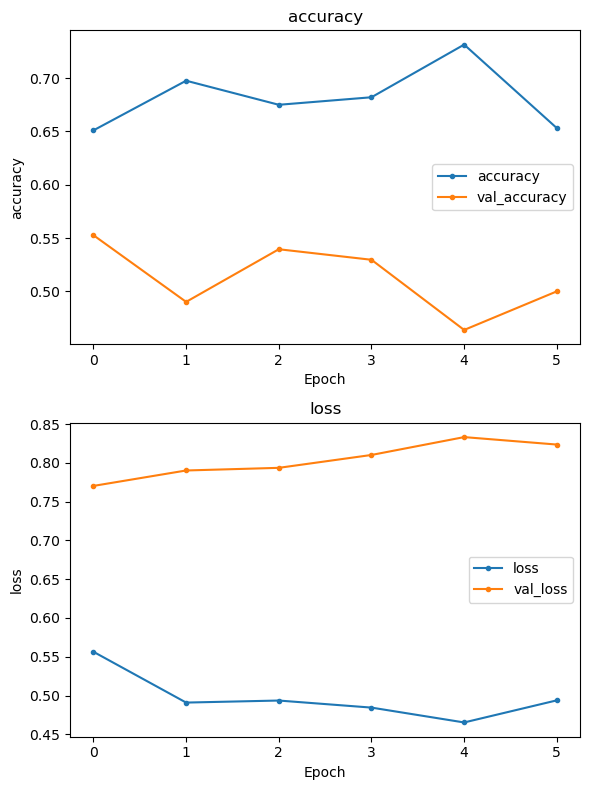

In [34]:
EPOCHS = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)


# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop]
)
plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       720
           1       0.69      0.51      0.59       698

    accuracy                           0.65      1418
   macro avg       0.66      0.65      0.64      1418
weighted avg       0.66      0.65      0.64      1418



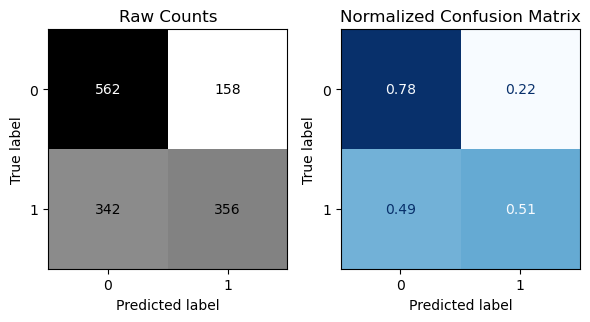


- Evaluating Training Data:
45/45 [==============================] - 0s 7ms/step - loss: 0.4950 - accuracy: 0.6474
{'loss': 0.49503087997436523, 'accuracy': 0.6473906636238098}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.64      0.56       152
           1       0.50      0.36      0.42       152

    accuracy                           0.50       304
   macro avg       0.50      0.50      0.49       304
weighted avg       0.50      0.50      0.49       304



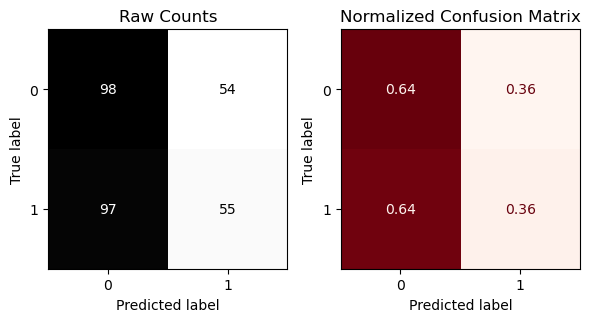


- Evaluating Test Data:
10/10 [==============================] - 0s 7ms/step - loss: 0.7323 - accuracy: 0.5033
{'loss': 0.7323191165924072, 'accuracy': 0.5032894611358643}


In [36]:
# Obtain the results
results = evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [39]:
# Adding a third dimension to prevent errors
stacked_vectors_tf = tf.expand_dims(0)
stacked_vectors_tf.shape

TypeError: Missing required positional argument